In [1]:
import sys
sys.path.append("/home/vpetukhov/other/NLPProjects/DMTransfer/")

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import umap
import pandas as pd

from src.mnn_umap import prepare_umap_graph, full_umap
from src.parsing import read_post_data, get_html_parser

from scripts.graph_clustering import get_igraph_from_umap_graph, two_level_clustering

from tqdm.notebook import tqdm
tqdm.pandas()

Ideas:
- Timeline with key posts on a topic
  - Add time dimension to my search engine?
- Convert dendrogram into an actual table of content
- Propagate post tags to users, show most active users per dendrogram branch
- Improve coloschemes
- Add time selection

Improving visualization:
- Try poincare embeddings
- Try sentence transformers instead of word2vec

In [2]:
posts = read_post_data('./data/posts.csv')
posts_encoded = pd.read_csv("./cache/posts_encoded.csv", index_col=0)

posts = posts.loc[posts_encoded.index]
posts['body'] = posts_encoded.body
posts_encoded = posts_encoded.iloc[:,:-1]

posts = posts[posts.postedAt.dt.year > 2005]
posts_encoded = posts_encoded.loc[posts.index]

posts_encoded.shape

(10761, 384)

In [3]:
# h2t = get_html_parser()
# posts['body'] = posts['htmlBody'].progress_apply(h2t.handle)
posts['text'] = posts['title'] + "\n\n" + posts['body']

## Prepare data

TODO:
- try to embed by sentence
- Use default SBERT as a baseline

In [4]:
from scripts.graph_clustering import get_igraph_from_umap_graph, two_level_clustering
from scripts.preprocessing import normalize_text_doc, create_text_corp
from scripts.keyword_extraction import get_keywords_for_hierarchy, convert_keywords_to_cluster_names

### Normal UMAP

In [5]:
from umap import UMAP

umap = UMAP(metric="cosine", n_neighbors=30, spread=10, min_dist=0.5, n_components=2, random_state=42, n_epochs=1000)
embedding = umap.fit_transform(posts_encoded)

/home/vpetukhov/local/miniconda3/envs/pip/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


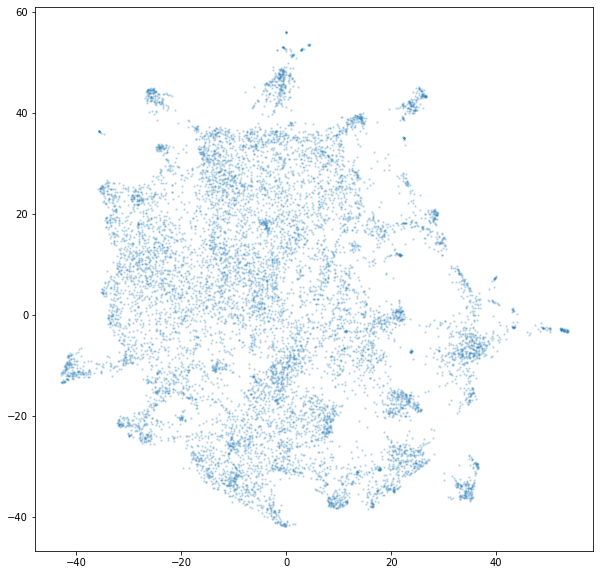

In [6]:
plt.figure(figsize=(10,10))
plt.scatter(embedding[:,0], embedding[:,1], s=2, alpha=0.2)

### Parametric UMAP

In [110]:
# from umap.parametric_umap import ParametricUMAP

# pumap = ParametricUMAP()
# embedding = pumap.fit_transform(posts_encoded, metric="cosine", n_epochs=1000, verbose=True)

### MNN UMAP

In [7]:
umap_graph = prepare_umap_graph(posts_encoded, metric="cosine", init_nn=30, connectivity="min_tree", verbose=False)

In [8]:
mnn_emb = full_umap(
    posts_encoded, umap_graph, 
    spread=10, min_dist=0.5, 
    metric="cosine", random_state=42, verbose=True, n_epochs=2000
)

/home/vpetukhov/local/miniconda3/envs/pip/lib/python3.8/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
100%|██████████| 2000/2000 [03:04<00:00, 10.83it/s]


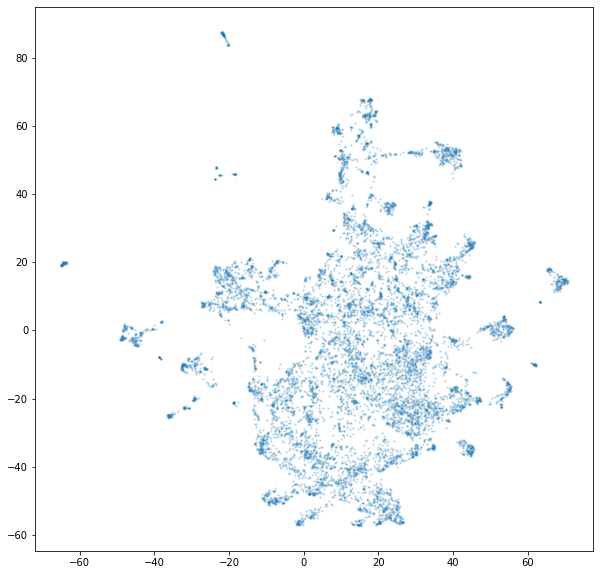

In [9]:
plt.figure(figsize=(10,10))
plt.scatter(mnn_emb[:,0], mnn_emb[:,1], s=2, alpha=0.2)

In [99]:
post_lengths = posts['body'].map(lambda x: len(x.split())).values
n_tags_per_post = np.minimum(posts['tags'].map(len).values, 10)

In [97]:
# plt.hist(np.log10(post_lengths))

In [120]:
# plt.figure(figsize=(10,10))
# # plt.scatter(mnn_emb[:,0], mnn_emb[:,1], s=2, alpha=0.2, c=np.log10(post_lengths))
# # plt.scatter(mnn_emb[:,0], mnn_emb[:,1], s=2, alpha=0.2, c=n_tags_per_post)
# mask = (n_tags_per_post <= 1)
# plt.scatter(mnn_emb[mask,0], mnn_emb[mask,1], s=2, alpha=0.2)

# plt.figure(figsize=(10,10))
# plt.scatter(mnn_emb[~mask,0], mnn_emb[~mask,1], s=2, alpha=0.2)

In [37]:
i_graph = get_igraph_from_umap_graph(None, graph=umap_graph)

In [132]:
from sklearn.cluster import SpectralClustering

adj_mat = (umap_graph.A + umap_graph.A.T) / 2
spect_clusts = SpectralClustering(n_clusters=5, affinity='precomputed', n_jobs=1, verbose=True).fit(adj_mat).labels_

[autoreload of threadpoolctl failed: Traceback (most recent call last):
  File "/home/vpetukhov/local/miniconda3/envs/pip/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/vpetukhov/local/miniconda3/envs/pip/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/vpetukhov/local/miniconda3/envs/pip/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/vpetukhov/local/miniconda3/envs/pip/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/vpetukhov/local/miniconda3/envs/pip/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/vpetukhov/local/miniconda3/envs/pip/lib/python3.8/site-pa

In [41]:
clustering_info = two_level_clustering(
    i_graph, posts_encoded.values, 
    top_level_resolution=0.0005, second_level_resolution=0.003, 
    min_size_level1=10, min_size_level2=10
)

len(set(clustering_info['clusters_1_level'])), len(set(clustering_info['global_numbering_clusters_2_level']))

(11, 53)

In [42]:
documents_norm = posts.text.progress_map(normalize_text_doc).values
documents = [' '.join(doc) for doc in documents_norm]

  0%|          | 0/10763 [00:00<?, ?it/s]

In [43]:
documents = [' '.join(doc) for doc in documents_norm]

In [48]:
from scripts.keyword_extraction import get_top_keywords_for_cluster

In [79]:
kws = get_top_keywords_for_cluster(
    # text_corp, clustering_info['clusters_1_level'], vectorizer.get_feature_names_out(), n_terms=5, tag_types=None
    text_corp, clustering_info['global_numbering_clusters_2_level'], vectorizer.get_feature_names_out(), n_terms=5, tag_types=None
)

# kws

In [80]:
# text_corp, vectorizer = create_text_corp(documents)
res_kw = get_keywords_for_hierarchy(clustering_info, text_corp, feature_names=vectorizer.get_feature_names_out())

0
1


In [81]:
clust_labels, clust_labels2 = convert_keywords_to_cluster_names(res_kw, clustering_info)

In [82]:
posts.head(2)

,title,htmlBody,pageUrl,postedAt,baseScore,voteCount,commentCount,meta,question,url,tags,user,coauthors,userId,body,text
2258qMLTjTu4L77Fu,Can you suggest guidelines for setting / renew...,"<p>Hi EA community,</p><p>This is my first pos...",https://forum.effectivealtruism.org/posts/2258...,2020-05-14 18:24:32.423000+00:00,10,4,NaN,False,True,NaN,[Career choice],Barth,[],2fpSGdf4ofpkhvKjt,"Hi EA community,\n\nThis is my first post here...",Can you suggest guidelines for setting / renew...
225Aq4P4jFPoWBrb5,Cause prioritization for downside-focused valu...,<p><em>Last updated: July 8th 2021. </em> </p>...,https://forum.effectivealtruism.org/posts/225A...,2018-01-31 14:47:11.961000+00:00,72,51,10.0,False,False,NaN,"[Cause prioritization, Philosophy of effective...",Lukas_Gloor,[],2tRAtc3DtRKjL8hsS,Last updated: July 8th 2021. \n\nThis post out...,Cause prioritization for downside-focused valu...


In [83]:
art_df = posts[['title', 'pageUrl', 'baseScore', 'commentCount']].reset_index(drop=True).copy()

date = pd.to_datetime(posts['postedAt']).dt
art_df['date'] = date.date.values
art_df['year'] = date.year.values

art_df['text'] = posts['body'].map(lambda x: ' ' .join(x.split(' ')[:150]) + '...')
art_df['url'] = posts.pageUrl.values

# art_df['text'] = art_df.abstract.values
art_df['log_score'] = np.log10(np.abs(art_df.baseScore) + 1) * np.sign(art_df.baseScore)
art_df['log_n_comments'] = np.log10(art_df.commentCount + 1)

art_df['clust1'] = clust_labels
art_df['clust2'] = clust_labels2

res_arch = dict(
    keyword_info=res_kw,
    embedding=mnn_emb,
    art_df=art_df,
    clusters_columns=['clust1', 'clust2', 'year', 'log_score', 'log_n_comments'],
    metadata_columns=['title', 'baseScore', 'commentCount'],
    scatter_params=dict(annotation_col='clust1', ms=3.5),
    metadata=None,
)

pd.to_pickle(res_arch, "./cache/sbert_emb_data.pkl")